# General Setup

In [1]:
%matplotlib widget

from pyCascade import probePost, physics
from matplotlib import pyplot as plt
import numpy as np
import os

category =  "single_family"


In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

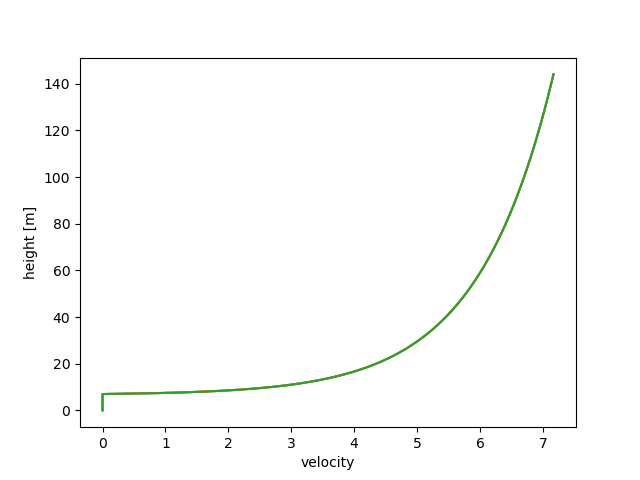

In [3]:
vK_const = 0.4
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
Lz =  24*hm
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'vK_const': vK_const,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,Lz*10)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [4]:
physics_setup.plot_spinup_velocity()

u_bulk is 5.686382916184899
domain height is 144.0


In [5]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 7.168206228236349 with L = 144.0
flat plate Reynolds number is 70606871.40740058
wall spacing is 0.03251964367353289 for y+ of 500


In [6]:
# NEED TO EXTRACT BETTER NORMALIZING CONSTANT
physics_setup.LES_params['uStar']
physics_setup.LES_params['z_values'][330]
physics_setup.LES_params['log_wind'][330]



5.172260845042926

In [7]:
window_dim = hm/2/4

velocity_scaling = 1/physics_setup.LES_params['log_wind'][330]
ventilation_scaling = velocity_scaling/(window_dim**2)
                                        
norm_vel = lambda data_df : data_df*velocity_scaling
norm_vent = lambda data_df : data_df*ventilation_scaling

# Run

In [8]:
run = 15
qois = ['comp(u,0)', 'comp(u,2)']

In [9]:
import pyarrow as ar
from pyarrow import csv, cpu_count
import time

def skip_comment(row):
    if row.text.startswith("# "):
        return 'skip'
    else:
        return 'error'

def read_probes(filename):
#     ar.set_io_thread_count(36)
#     ar.io_thread_count()
#     ar.set_cpu_count(36)
    print(f"Pyarrow reading PROBE file on {cpu_count()} threads")
    read_options = csv.ReadOptions(skip_rows = 5, autogenerate_column_names = True, use_threads = True, block_size = 1e7)
    parse_options = csv.ParseOptions(delimiter=" ", invalid_row_handler=skip_comment)
    pyarrow_table = csv.read_csv(filename, read_options, parse_options)
    df = pyarrow_table.to_pandas()
    df = df.transpose()
    new_header = df.iloc[1] #grab the second row for the header
    df = df[3:].reset_index(drop=True) #take the data less the header row
    df.columns = new_header #set the header row as the df header
    return df.stack().to_dict()  # save as tuple indexed dictionary

ar.io_thread_count()


8

In [10]:
start = time.time()
data = read_probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut/col_3-2.comp(u,0)')
end = time.time()
print(end-start)

Pyarrow reading PROBE file on 1 threads
64.21824264526367


In [20]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

Pyarrow reading PROBE file on 32 threads


KeyboardInterrupt: 

In [ ]:
# ## 10 m flow statistics
# ref_flow = probes.statistics(
#     names = [name for name in  probes.probe_names if "col" in name], 
#     steps = probes.probe_steps[0:-1:1],
#     quants = ['comp(u,0)','comp(u,2)' ],
#     stack = probes.probe_stack[11],
#     processing = [probePost.time_average],
#     parrallel=True
#     )

In [ ]:
# ref_flow.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/10m_flow')

In [ ]:
norm_data = lambda data_df : data_df*ventilation_scaling

plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    'ColorNorm': 'Centered',
    'veritcal scaling' : 1
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-1:-10:1],
    quants = ['comp(u,0)'],#'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

In [25]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

slicing took 0 seconds
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 0 seconds
memorizing data took 0 seconds
processing data took 0 seconds


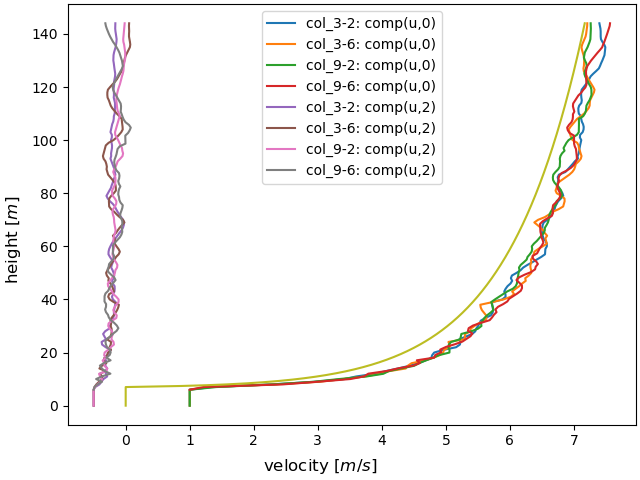

In [18]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[0],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'velocity $[m/s]$',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [19]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

In [14]:
# plot_params = {
#     'plot_levels' : {
#         'comp(u,0)' : np.linspace(0,.1,200),
#         'comp(u,1)' : np.linspace(0,.1,200),
#         'comp(u,2)' : np.linspace(0,.1,200)
#     },
#     'horizontal spacing' : physics_setup.LES_params['Dt'],
#     'stack span' : 'y',
#     'xlabel': 'time [s]',
#     'ylabel' : 'height',
#     'plot_every': 100
# }

# # slice = probes.slice_into_df(slice_params)
# (fig, ax) = probes.contour_plots(
#     names = [name for name in  probes.probe_names if "col" in name], 
#     steps = probes.probe_steps[:-10:1],
#     quants = ['comp(u,2)'],
#     parrallel = True,
#     processing = [probePost.mean_convergence],
#     plot_params = plot_params
#     )

In [34]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_convergence')

## X Flow


slicing took 0 seconds
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 108 seconds
memorizing data took 2 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:368: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 2 seconds
slicing took 0 seconds
reading data took 1 seconds
memorizing data took 3 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 1 seconds
memorizing data took 3 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 1 seconds
memorizing data took 3 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds


name,xwindow_0-0,xwindow_0-1,xwindow_2-0,xwindow_2-1
var,,,,
"comp(u,0)",0.278331,0.2635,0.114269,0.326978


name,xwindow_0-0,xwindow_0-1,xwindow_2-0,xwindow_2-1
var,,,,
"comp(u,0)",0.259503,0.250169,0.390755,0.303816


name,xwindow_0-0,xwindow_0-1,xwindow_2-0,xwindow_2-1
var,,,,
"comp(u,0)",0.479634,0.447579,0.53118,0.538799


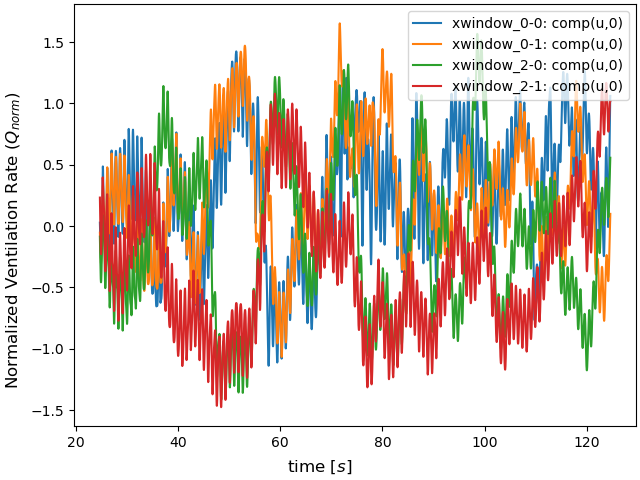

In [20]:
start = -10000
stop = -1
by = 1

norm_norm = lambda df : probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
abs_values = lambda df : df.abs()
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(x_mean)
display(x_rms)
display(x_net)

In [21]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


slicing took 0 seconds
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 15 seconds
memorizing data took 0 seconds
processing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:368: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


slicing took 0 seconds
reading data took 0 seconds
memorizing data took 0 seconds
processing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


slicing took 0 seconds
reading data took 0 seconds
memorizing data took 1 seconds
processing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


slicing took 0 seconds
reading data took 0 seconds
memorizing data took 0 seconds
processing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:425: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


name,zwindow_0-0,zwindow_0-1,zwindow_1-0,zwindow_1-1,zwindow_2-0,zwindow_2-1
var,,,,,,
"comp(u,2)",-0.136273,-0.020452,-0.05225,-0.031388,0.016833,-0.048147


name,zwindow_0-0,zwindow_0-1,zwindow_1-0,zwindow_1-1,zwindow_2-0,zwindow_2-1
var,,,,,,
"comp(u,2)",0.235277,0.427413,0.168242,0.223631,0.166869,0.143658


name,zwindow_0-0,zwindow_0-1,zwindow_1-0,zwindow_1-1,zwindow_2-0,zwindow_2-1
var,,,,,,
"comp(u,0)",0.621775,0.855465,0.735753,1.190481,0.718606,1.324624


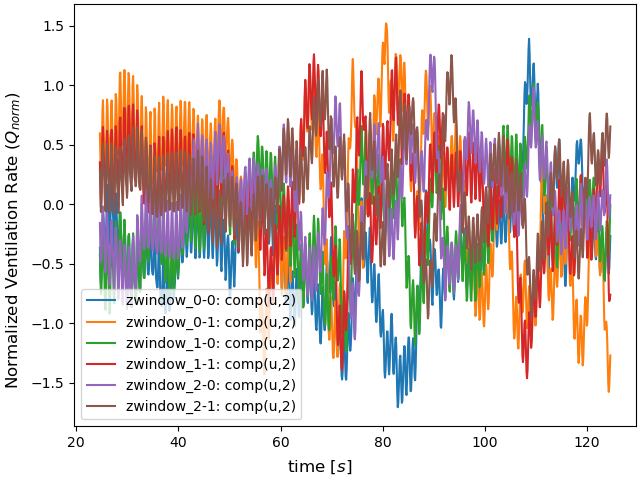

In [22]:
start = -10000
stop = -1
by = 10

norm_norm = lambda df : probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
abs_values = lambda df : df.abs()
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

In [23]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Other Post Processing

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 6 seconds
memorizing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:368: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:382: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, constrained_layout =True)


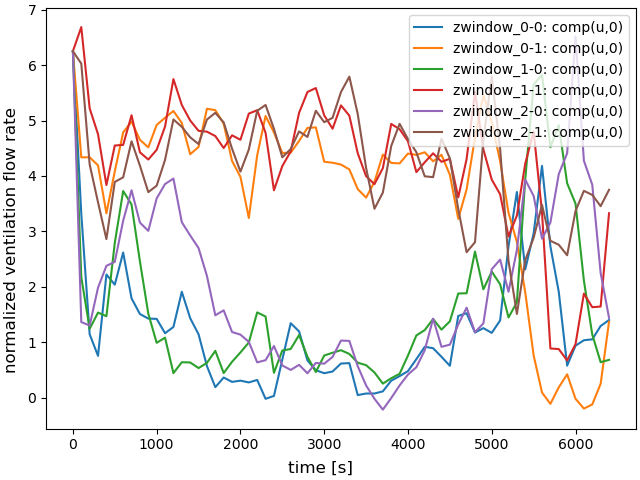

In [39]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:100],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'normalized ventilation flow rate',
        'xlabel' : 'time [s]',
        'qoi_scaling' : 1/1.0625
        },
    processing = [probePost.ClenshawCurtis_Quadrature],
    parrallel=True
    )

In [ ]:
## mean statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

slicing took 0 seconds


In [ ]:
## rms statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

In [ ]:
# probes.probe_stack

In [ ]:
## 10 m flow statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    stack = probes.probe_stack[33],
    processing = [probePost.time_average],
    parrallel=True
    )

In [ ]:
video_dir = f'{home_dir}/CHARLES/{category}/R{run}/Videos'
video_series = "u_y2"

!pwd
!echo "saving videos to: "
%cd $video_dir
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y2". --dt .1 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y5". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y8". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y20". --dt 2 --subsample 1
!echo "returning to: "
%cd -